<a href="https://colab.research.google.com/github/rob004/polynomial-interpolator.ipynb/blob/main/polynomial_interpolator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Implementação: Interpolador Polinomial

**Roberto de Morais Junior**


## 1. Introdução

A interpolação polinomial é uma técnica matemática fundamental para encontrar um polinômio que passa exatamente por um conjunto de pontos dados. Imagine "ligar os pontos" de um gráfico, mas em vez de usar retas, usamos uma curva suave definida por um único polinômio.

Este trabalho implementa um programa em Python que:
- Solicita ao usuário um conjunto de pontos $(x, y)$.
- Valida esses pontos para garantir que a interpolação seja possível.
- Calcula o polinômio interpolador usando dois métodos à escolha:

    **Método de Lagrange**

    **Método das Diferenças Divididas de Newton**
- Exibe o polinômio resultante e visualiza o resultado em um gráfico.

## 2. Fundamentação Teórica

Para um conjunto de $n$ pontos $(x_0, y_0), (x_1, y_1), \dots, (x_{n-1}, y_{n-1})$, queremos encontrar um polinômio $P(x)$ de grau no máximo $n-1$ tal que $P(x_i) = y_i$ para todos os pontos $i$.

### 2.1. Método de Lagrange

O método de Lagrange constrói o polinômio como uma soma de polinômios base $L_i(x)$, onde cada $L_i(x)$ tem a propriedade de ser 1 em $x_i$ e 0 em todos os outros $x_j$ (com $j \neq i$).

O polinômio interpolador $P(x)$ é dado por:
$$ P(x) = \sum_{i=0}^{n-1} y_i \cdot L_i(x) $$
Onde cada polinômio base $L_i(x)$ é:
$$ L_i(x) = \prod_{j=0, j \neq i}^{n-1} \frac{x - x_j}{x_i - x_j} $$

### 2.2. Método das Diferenças Divididas de Newton

Este método constrói o polinômio de forma incremental. A forma do polinômio de Newton é:
$$ P(x) = f[x_0] + f[x_0, x_1](x - x_0) + f[x_0, x_1, x_2](x - x_0)(x - x_1) + \dots + f[x_0, \dots, x_{n-1}] \prod_{i=0}^{n-2} (x - x_i) $$
Onde os coeficientes $f[x_0, \dots, x_k]$ são as "diferenças divididas", calculadas a partir de uma tabela. Por exemplo:
- $f[x_i] = y_i$
- $f[x_i, x_j] = \frac{f[x_j] - f[x_i]}{x_j - x_i}$
- $f[x_i, x_j, x_k] = \frac{f[x_j, x_k] - f[x_i, x_j]}{x_k - x_i}$

ENTRADA DE PONTOS PARA INTERPOLAÇÃO
Instrução: Insira os pontos no formato 'x,y' (ex: 2,5)
Digite 'fim' quando tiver inserido todos os pontos.
Digite o ponto 1 (ou 'fim'): 3,8
Digite o ponto 2 (ou 'fim'): fim

Erro: São necessários pelo menos 2 pontos para interpolar. Tente novamente.
Digite o ponto 1 (ou 'fim'): 3.8
Erro: Formato inválido. Por favor, insira no formato 'x,y'.
Digite o ponto 1 (ou 'fim'): 2,4
Digite o ponto 2 (ou 'fim'): fim

Erro: São necessários pelo menos 2 pontos para interpolar. Tente novamente.
Digite o ponto 1 (ou 'fim'): 2,8
Digite o ponto 2 (ou 'fim'): 3,9
Digite o ponto 3 (ou 'fim'): 4,8
Digite o ponto 4 (ou 'fim'): fim

Validação: Os pontos são válidos para interpolação.

Escolha o método de interpolação:
1 - Método de Lagrange
2 - Método das Diferenças Divididas de Newton
Digite sua escolha (1 ou 2): 1

Calculando o polinômio interpolador pelo método de Lagrange...
Gerando o gráfico da interpolação...


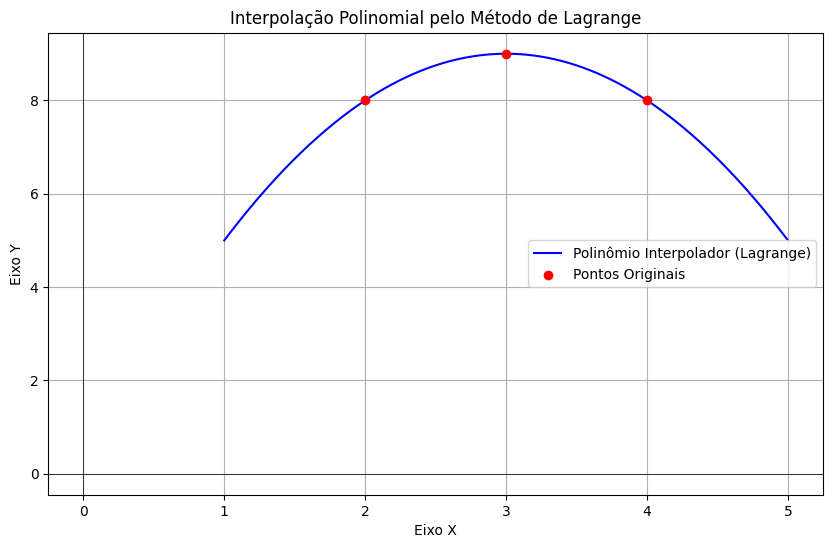


O polinômio foi criado com sucesso!
Você pode usá-lo para estimar valores.


KeyboardInterrupt: Interrupted by user

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def obter_pontos_usuario():

    pontos_x = []
    pontos_y = []
    print("="*50)
    print("ENTRADA DE PONTOS PARA INTERPOLAÇÃO")
    print("Instrução: Insira os pontos no formato 'x,y' (ex: 2,5)")
    print("Digite 'fim' quando tiver inserido todos os pontos.")
    print("="*50)

    while True:
        entrada = input(f"Digite o ponto {len(pontos_x) + 1} (ou 'fim'): ")
        if entrada.lower() == 'fim':
            if len(pontos_x) < 2:
                print("\nErro: São necessários pelo menos 2 pontos para interpolar. Tente novamente.")
                # Reinicia a coleta se não houver pontos suficientes
                pontos_x, pontos_y = [], []
                continue
            else:
                break

        try:
            # Tenta dividir a entrada em x e y
            x_str, y_str = entrada.split(',')
            x = float(x_str)
            y = float(y_str)
            pontos_x.append(x)
            pontos_y.append(y)
        except ValueError:
            print("Erro: Formato inválido. Por favor, insira no formato 'x,y'.")

    return np.array(pontos_x), np.array(pontos_y)

def validar_pontos(pontos_x):

    # A função set() remove elementos duplicados. Se o tamanho do set for
    # menor que o da lista original, significa que havia x repetidos.
    if len(set(pontos_x)) < len(pontos_x):
        print("\nErro de Validação: Existem pontos com o mesmo valor de x. A interpolação não é possível.")
        return False

    print("\nValidação: Os pontos são válidos para interpolação.")
    return True



def criar_polinomio_lagrange(pontos_x, pontos_y):
    """
    Cria uma função que representa o polinômio interpolador de Lagrange.
    Retorna uma função P(x) que pode ser chamada para calcular o valor do
    polinômio em qualquer ponto x.
    """
    n = len(pontos_x)

    # Definimos a função P(x) que será retornada
    def P(x):
        resultado_total = 0.0
        # Soma dos termos y_i * L_i(x)
        for i in range(n):
            # Calcula o polinômio base L_i(x)
            termo_li = 1.0
            for j in range(n):
                if i != j:
                    termo_li = termo_li * (x - pontos_x[j]) / (pontos_x[i] - pontos_x[j])

            resultado_total += pontos_y[i] * termo_li
        return resultado_total

    return P

# --- Método das Diferenças Divididas de Newton ---
def calcular_tabela_diferencas_divididas(pontos_x, pontos_y):

    n = len(pontos_x)
    # Inicializa a tabela de coeficientes com os valores de y
    tabela = np.zeros([n, n])
    tabela[:, 0] = pontos_y

    # Preenche a tabela
    for j in range(1, n):
        for i in range(n - j):
            numerador = tabela[i + 1, j - 1] - tabela[i, j - 1]
            denominador = pontos_x[i + j] - pontos_x[i]
            tabela[i, j] = numerador / denominador

    # Os coeficientes são a primeira linha da tabela
    return tabela[0]

def criar_polinomio_newton(pontos_x, pontos_y):

    coeficientes = calcular_tabela_diferencas_divididas(pontos_x, pontos_y)
    n = len(pontos_x)

    # Definimos a função P(x) que será retornada
    def P(x):
        resultado_total = 0.0
        # Constrói o polinômio de forma aninhada (mais eficiente - Forma de Horner)
        # P(x) = c0 + (x-x0)(c1 + (x-x1)(c2 + ...))
        for i in range(n - 1, -1, -1):
             resultado_total = resultado_total * (x - pontos_x[i]) + coeficientes[i]
        return resultado_total

    return P


def visualizar_interpolacao(pontos_x, pontos_y, polinomio, metodo):

    x_curva = np.linspace(min(pontos_x) - 1, max(pontos_x) + 1, 400)
    y_curva = polinomio(x_curva)

    plt.figure(figsize=(10, 6))
    plt.plot(x_curva, y_curva, label=f'Polinômio Interpolador ({metodo})', color='blue')
    plt.scatter(pontos_x, pontos_y, color='red', zorder=5, label='Pontos Originais')

    plt.title(f'Interpolação Polinomial pelo Método de {metodo}')
    plt.xlabel('Eixo X')
    plt.ylabel('Eixo Y')
    plt.legend()
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.show()

def main():

    #obter e validar os pontos do usuário
    while True:
        px, py = obter_pontos_usuario()
        if validar_pontos(px):
            break
        else:
            print("Por favor, insira os pontos novamente.\n")

    #permitir que o usuário escolha o método
    print("\nEscolha o método de interpolação:")
    print("1 - Método de Lagrange")
    print("2 - Método das Diferenças Divididas de Newton")

    escolha = ""
    while escolha not in ['1', '2']:
        escolha = input("Digite sua escolha (1 ou 2): ")

    #calcular e visualizar o polinômio
    if escolha == '1':
        metodo_nome = "Lagrange"
        polinomio = criar_polinomio_lagrange(px, py)
        print(f"\nCalculando o polinômio interpolador pelo método de {metodo_nome}...")
    else:
        metodo_nome = "Newton"
        polinomio = criar_polinomio_newton(px, py)
        print(f"\nCalculando o polinômio interpolador pelo método de {metodo_nome}...")

    #mostrar o gráfico
    print("Gerando o gráfico da interpolação...")
    visualizar_interpolacao(px, py, polinomio, metodo_nome)

    #como usar o polinômio para encontrar um valor
    print("\nO polinômio foi criado com sucesso!")
    print("Você pode usá-lo para estimar valores.")
    while True:
        try:
            x_teste_str = input("Digite um valor de x para testar o polinômio (ou 'sair'): ")
            if x_teste_str.lower() == 'sair':
                break
            x_teste = float(x_teste_str)
            y_estimado = polinomio(x_teste)
            print(f"Para x = {x_teste}, o valor estimado pelo polinômio é P(x) = {y_estimado:.4f}")
        except ValueError:
            print("Entrada inválida. Por favor, digite um número.")

# --- Ponto de entrada do script ---
# A linha abaixo garante que a função main() só será executada
# quando o script for rodado diretamente.
if __name__ == "__main__":
    main()